# Ice Games

En un mercado dinámico y en constante evolución como el de los videojuegos, comprender los patrones y tendencias es fundamental para el éxito comercial. En este contexto, Ice, una tienda en línea dedicada a la venta de videojuegos, se encuentra en la búsqueda de estrategias efectivas para identificar proyectos prometedores y planificar campañas publicitarias exitosas. Con el objetivo de aprovechar al máximo los datos disponibles, este proyecto se enfoca en analizar detalladamente las ventas de videojuegos entre los años de 1980 a 2016.

Para lograr este objetivo, se llevará a cabo un exhaustivo análisis de los datos disponibles, que incluyen información sobre el año de lanzamiento, las plataformas, los géneros, las ventas en diferentes regiones y las calificaciones de usuarios y expertos de cada juego. A través de este análisis, buscamos identificar patrones y relaciones significativas que nos ayuden a entender qué factores contribuyen al éxito de un juego y cómo podemos utilizar esta información para tomar decisiones informadas en cuanto a la selección de plataformas mas rentables y la planificación de campañas publicitarias.


## Preparación de los datos

In [1]:
import pandas as pd
from matplotlib import pyplot as plt 
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind, levene

In [2]:
games = pd.read_csv('games.csv')


In [3]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
#se remplaza el nombre de las columnas
new_columns = []

for old_name in games.columns:
    name_lower = old_name.lower()
    name_strip = name_lower.strip()
    name_replace = name_strip.replace(' ', '_')
    new_columns.append(name_replace)

games.columns = new_columns
games.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Manejo de valores ausentes y cambios de tipo

- Las columnas name y genre se llenan con Unknown ya que son pocos datos y son de tipo objeto, no se considera que puedan afectar a la integridad de los analisis futuros. 
- La columna year_of_release se llena con el año 2006 que es la mediana de los años en el listado, igualmente se verifica que el porcentaje de datos es poco 
- Los valores que se encuentran ausentes parecen ser por error en el vaciado y/o llenado de los mismos y en los casos de scores quiza los usuarios y la critica simplemente aun no los han calificado. 
- El valores de TBD en la columna rating se llenan con NAN para que no afecten los futuros calculos que se realizaran en esa columna; tomando en cuenta que dichos datos seran ignorados por python al momento de realizar dichos calculos. No se llenan con ningun valor como la media o la mediana, ya que al ser una cantidad importante de datos afectaria los calculos, tampoco se eliminan por la misma razon. 
- Se cambia el tipo de la columna year de flotante a entero, por cuestion meramente estetica y se cambia el tipo de la columna user_score de objeto a flotante, una vez transformados los valores tbd. Pues de no hacerlo las graficas y calculos futuros se verian afectados
- Los valores ausentes de otras columnas se debejan como estan, al no tener un dato con el que se pueda llenar sin afectar la integridad.
- Se crea la columna total_sales, la cual contiene la suma de las ventas en cada region por videojuego. 

In [5]:
games['name'] = games['name'].fillna('Unknown')
games['genre'] = games['genre'].fillna('Unknown')
games['year_of_release'] = games['year_of_release'].fillna(2006)


In [6]:
games['year_of_release'] = games['year_of_release'].astype(int)
games.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16715 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16715 non-null  int32  
 3   genre            16715 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(5), int32(1), object(5)
memory usage: 1.3+ MB


In [7]:

display(games[games['user_score'] == 'tbd'])
games['user_score'] = games['user_score'].replace('tbd', np.nan)
games['user_score'] = games['user_score'].astype(float)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
657,Frogger's Adventures: Temple of the Frog,GBA,2006,Adventure,2.15,0.18,0.0,0.07,73.0,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16695,Planet Monsters,GBA,2001,Action,0.01,0.00,0.0,0.00,67.0,tbd,E
16697,Bust-A-Move 3000,GC,2003,Puzzle,0.01,0.00,0.0,0.00,53.0,tbd,E
16698,Mega Brain Boost,DS,2008,Puzzle,0.01,0.00,0.0,0.00,48.0,tbd,E
16704,Plushees,DS,2008,Simulation,0.01,0.00,0.0,0.00,NaN,tbd,E


In [8]:
#creacion de la nueva columna que contiene las ventas totales por videojuego 
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

## Analisis de los datos

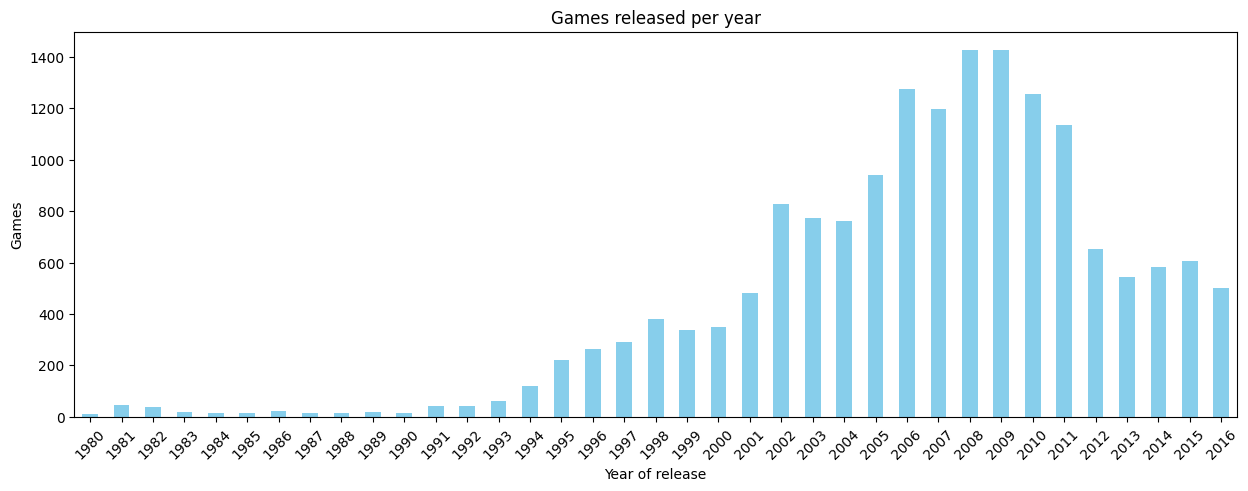

In [9]:
games_per_year = games.groupby('year_of_release')['name'].count()

plt.figure(figsize=(15, 5))
games_per_year.plot(kind='bar', color='skyblue')
plt.title('Games released per year')
plt.xlabel('Year of release')
plt.ylabel('Games')
plt.xticks(rotation=45)
plt.show()

Analizando la columna year of realease se observa que la cantidad de datos mas significativa esta en los años 2006 a 2011 y la menor cantidad de datos esta contenida entre los años de 1980 y 1994

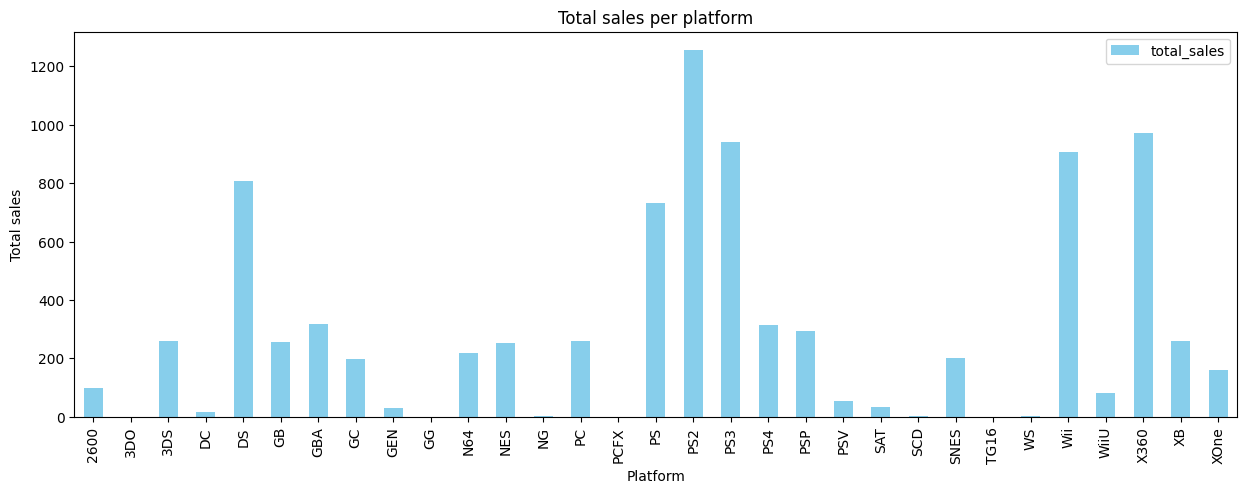

In [10]:
#variacion de las ventas de una plataforma a otra 
platform_sales = games.groupby('platform')['total_sales'].sum().reset_index()


platform_sales.plot(kind='bar', color= 'skyblue', figsize=(15, 5), x='platform')
plt.xlabel('Platform')
plt.ylabel('Total sales')
plt.title('Total sales per platform')

plt.show()


In [11]:
sales_mean_platform = platform_sales['total_sales'].mean()

sales_var_platform = platform_sales['total_sales'].var()

print(f"La media del total de ventas es: {sales_mean_platform}")

print(f"La varianza del total de ventas es: {sales_var_platform}")

La media del total de ventas es: 287.60354838709674
La varianza del total de ventas es: 121215.56380365587


Del grafico que presede se puede concluir que las plataformas con mayor cantidad de ventas han sido nintendo ds, playstation 2, 3 y 4 y xbox360. Se observa que las consolas presentan un despuente en ventas al momento de su salida y dichas ventas van disminuyendo entre mas tiempo transcurre de su estreno. La caida en las ventas parece tomarles entre 8 y 10 años posteriores al inicio de su comercializacion. Como ejemplo podemos observar al PS2 que para el año 2011 dejo de tener ventas, mientras que entre esos mismos años se observa las mayores ventas presentadas por PS3, que es su sucesor, y xbox 360.

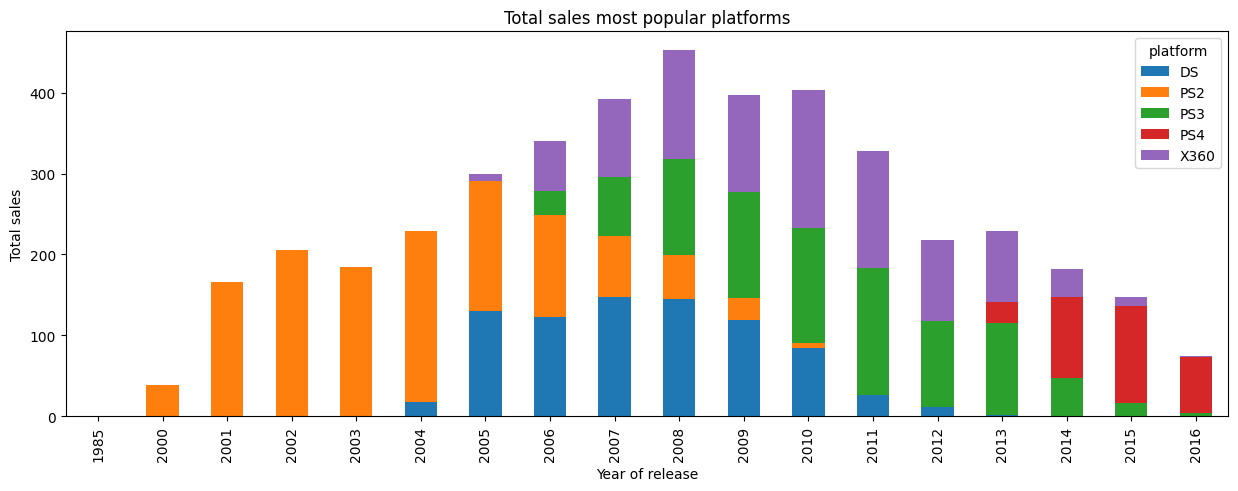

In [12]:

platforms = ['DS', 'PS2', 'X360', 'PS3', 'PS4']
platform_more_sales = games[games['platform'].isin(platforms)]
platform_more_sales1 = platform_more_sales.groupby(['platform', 'year_of_release'])['total_sales'].sum()


platform_more_sales1.unstack(level=0).plot(kind='bar', stacked=True, figsize=(15,5))
plt.xlabel('Year of release')

plt.ylabel('Total sales')

plt.title('Total sales most popular platforms')
plt.show()


Se observa que las plataformas lideres en ventas son el xbox 360 y PS3; asimismo podemos observar que por lo que respecta al Nintendo DS y PS2 son consolas que ya han perdido popularidad. Con base a los datos obtenidos, podriamos considerar que PS4 se apunta como una plataforma rentable para los siguientes años y las consolas suceras del Nintendo DS y del Xbox 360, tienen una alta probabilidad de convertirse en consolas rentables.

In [13]:
platform_more_sales['year_of_release'].value_counts().sort_values()

games_filtered = platform_more_sales.query('year_of_release > 2005 & year_of_release < 2016')

Para construir el modelo de prediccion de 2017, tomando en cuenta que a las plataformas les toma entre 8 y 10 años decender sus ventas desde el año de sus lanzamiento. Podriamos eligir datos del 2006 en adelante. Dado que al parecer los datos de los años 2016 podrian estar incompletos, tambien podriamos excluirlos para el modelo.

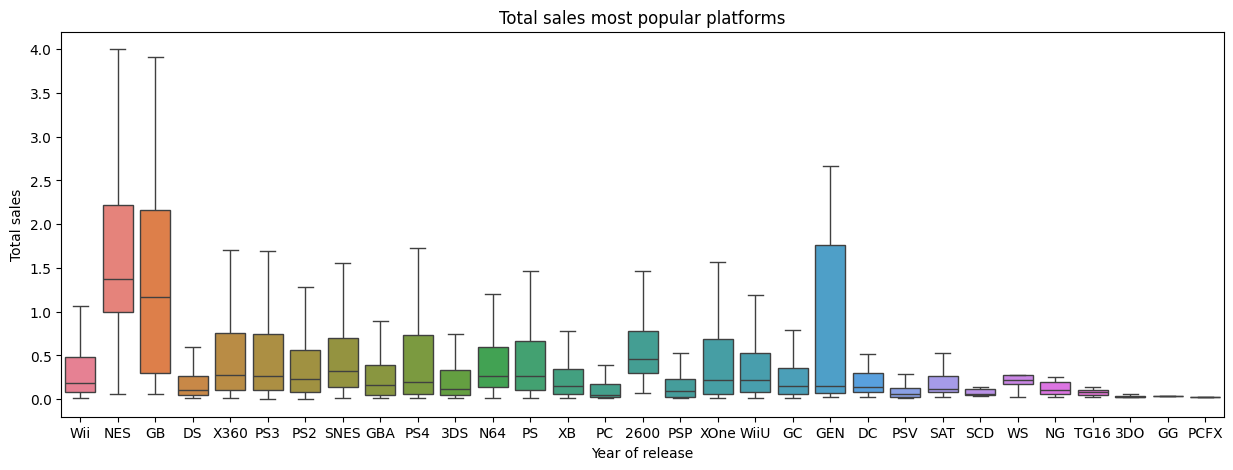

In [14]:
plt.figure(figsize=(15,5))

sns.boxplot(data=games, x='platform', y='total_sales', hue='platform', showfliers=False)

plt.xlabel('Year of release')

plt.ylabel('Total sales')

plt.title('Total sales most popular platforms')
plt.show()

In [15]:
sales_mean = games['total_sales'].mean()

sales_var = games['total_sales'].var()

print(f"La media del total de ventas es: {sales_mean}")

print(f"La varianza del total de ventas es: {sales_var}")

La media del total de ventas es: 0.533395752318277
La varianza del total de ventas es: 2.397112986544119


La mediana de los datos de la mayoria de las consolas se observa muy parecida. A excepcion de NES y GB; sin embargo, son consolas muy viejas y por tal motivo puede que no nos brinden informacion tan relevante. Todas las consolas tiene muchos datos atipicos, los cuales fueron eliminados del grafico para que no afecten la visibilidad del mismo. Estos datos atipicos podrian indicar que algunos juegos que fueron muy populares hicieron que las compras repuntaran en algun año para esa determinada consola. 

### Analisis de correlación por plataforma


#### PS4

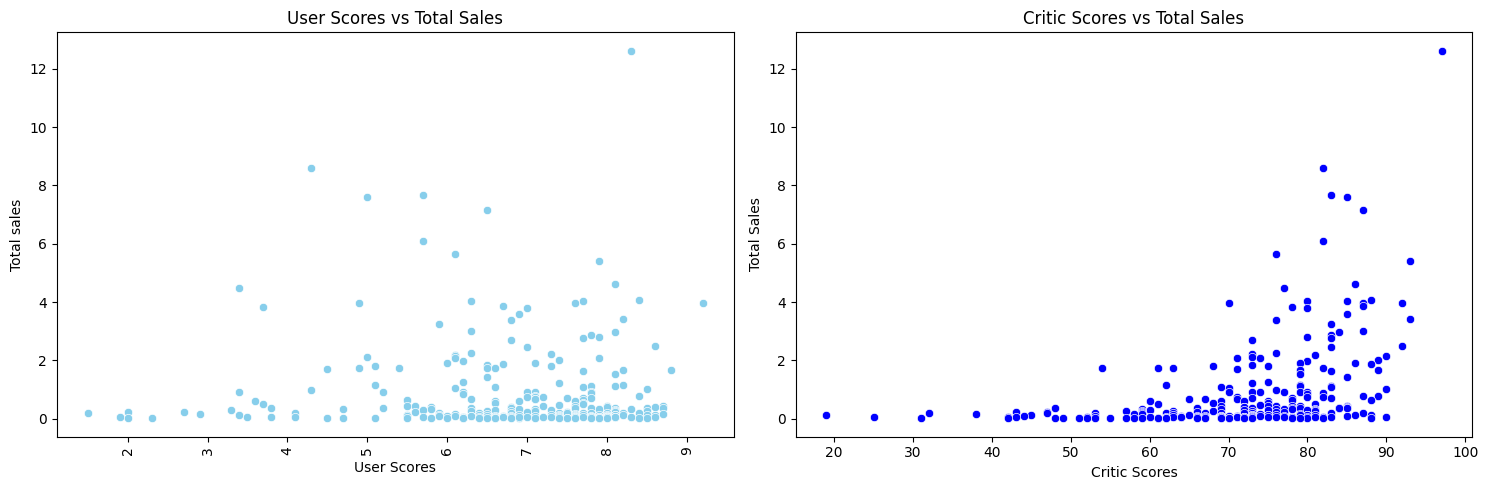

La correlación entre reseñas de usuarios y ventas es de: -0.0336249759652888
La correlación entre reseñas de profesionales y ventas es de: 0.4058948014583667


In [16]:

ps4_scores = games.query("platform == 'PS4'")
ps4_scores = ps4_scores.dropna(subset=['user_score', 'critic_score'])

ps4_scores['user_score'] = ps4_scores['user_score'].astype(float)
#ps4_scores = ps4_scores.sort_values(by='user_score')


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))


sns.scatterplot(data=ps4_scores, x='user_score', y='total_sales', ax=ax1, color='skyblue')
ax1.set_title('User Scores vs Total Sales')
ax1.set_xlabel('User Scores')
ax1.set_ylabel('Total sales')
plt.setp(ax1.get_xticklabels(), rotation=90) 


sns.scatterplot(data=ps4_scores, x='critic_score', y='total_sales', ax=ax2, color='blue')
ax2.set_title('Critic Scores vs Total Sales')
ax2.set_xlabel('Critic Scores')
ax2.set_ylabel('Total Sales')

plt.tight_layout()
plt.show()

correlation_user = ps4_scores['user_score'].corr(ps4_scores['total_sales'])
correlation_critic = ps4_scores['critic_score'].corr(ps4_scores['total_sales'])

print(f"La correlación entre reseñas de usuarios y ventas es de: {correlation_user}")
print(f"La correlación entre reseñas de profesionales y ventas es de: {correlation_critic}")




#### XBOX 360

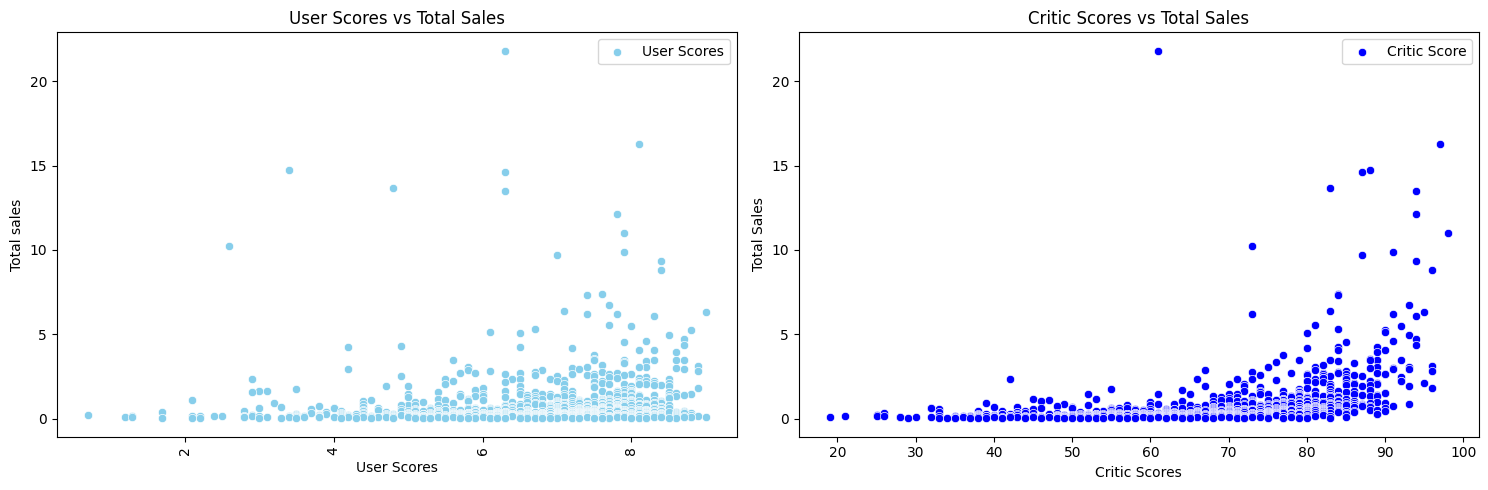

La correlación entre reseñas de usuarios y ventas es de: 0.1144588297845418
La correlación entre reseñas de profesionales y ventas es de: 0.3937358653072587


In [17]:
xbox_scores = games.query("platform == 'X360'")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))


sns.scatterplot(data=xbox_scores, x='user_score', y='total_sales', label='User Scores', ax=ax1, color='skyblue')
ax1.set_title('User Scores vs Total Sales')
ax1.set_xlabel('User Scores')
ax1.set_ylabel('Total sales')
plt.setp(ax1.get_xticklabels(), rotation=90) 


sns.scatterplot(data=xbox_scores, x='critic_score', y='total_sales', label='Critic Score', ax=ax2, color='blue')
ax2.set_title('Critic Scores vs Total Sales')
ax2.set_xlabel('Critic Scores')
ax2.set_ylabel('Total Sales')

plt.tight_layout()
plt.show()

correlation_user = xbox_scores['user_score'].corr(xbox_scores['total_sales'])
correlation_critic = xbox_scores['critic_score'].corr(xbox_scores['total_sales'])

print(f"La correlación entre reseñas de usuarios y ventas es de: {correlation_user}")
print(f"La correlación entre reseñas de profesionales y ventas es de: {correlation_critic}")

#### DS

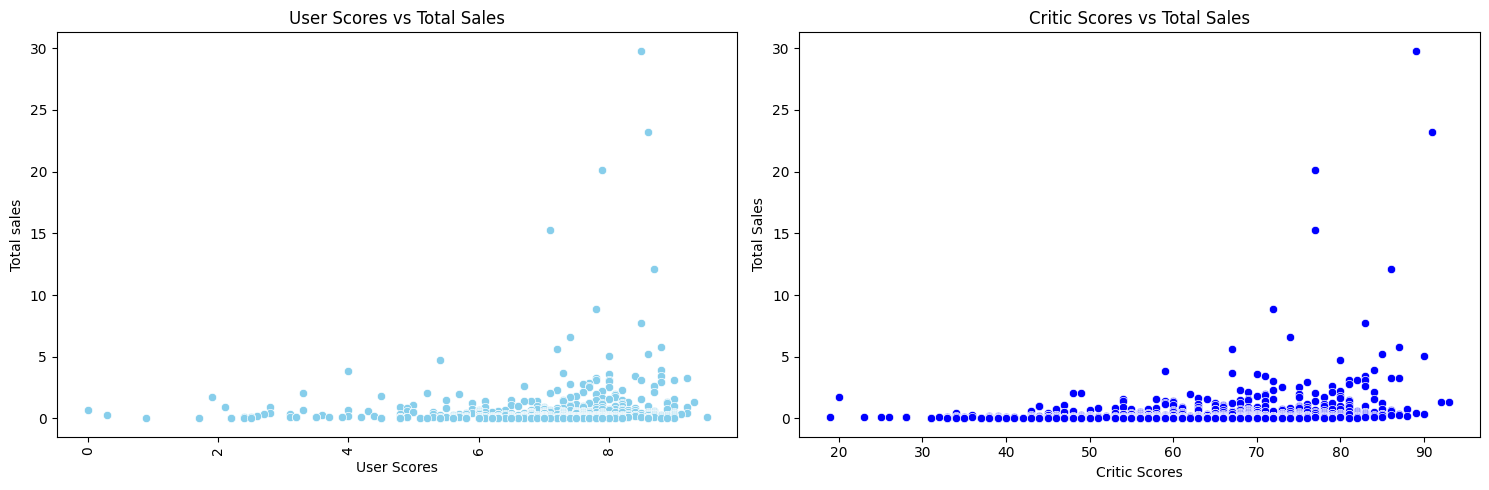

La correlación entre reseñas de usuarios y ventas es de: 0.13043550111642493
La correlación entre reseñas de profesionales y ventas es de: 0.23637945738859698


In [18]:
ds_scores = games.query("platform == 'DS'")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))


sns.scatterplot(data=ds_scores, x='user_score', y='total_sales',  ax=ax1, color='skyblue')
ax1.set_title('User Scores vs Total Sales')
ax1.set_xlabel('User Scores')
ax1.set_ylabel('Total sales')
plt.setp(ax1.get_xticklabels(), rotation=90) 


sns.scatterplot(data=ds_scores, x='critic_score', y='total_sales', ax=ax2, color='blue')
ax2.set_title('Critic Scores vs Total Sales')
ax2.set_xlabel('Critic Scores')
ax2.set_ylabel('Total Sales')

plt.tight_layout()
plt.show()

correlation_user = ds_scores['user_score'].corr(ds_scores['total_sales'])
correlation_critic = ds_scores['critic_score'].corr(ds_scores['total_sales'])

print(f"La correlación entre reseñas de usuarios y ventas es de: {correlation_user}")
print(f"La correlación entre reseñas de profesionales y ventas es de: {correlation_critic}")

Deribado de los graficos y calculos anteriores podemos observar que la correlacion entre las criticas, tanto de los usuarios como de los expertos, con las ventas totales es casi nula, lo que quiere decir que los scores de dichas criticas no afecatan a las ventas. Se puse observar que en el caso de los scores de los expertos, aquellos por encima de 80 logran afectar un poco las ventas sin que esto sea determinante. Lo mostrado en las graficas se corrobora al calcular la correlacion entre estas variable, pues la misma muestra valores muy cercanos a 0 y en algunos casos, valores negativos. Esta tendencia se observa en las 3 consolas que decidimos analizar, que fueron elegidas por ser representativas de compañias distintas y tambien por haber mostrado liderazgo en ventas de los analisis realizados en los puntos anteriores.

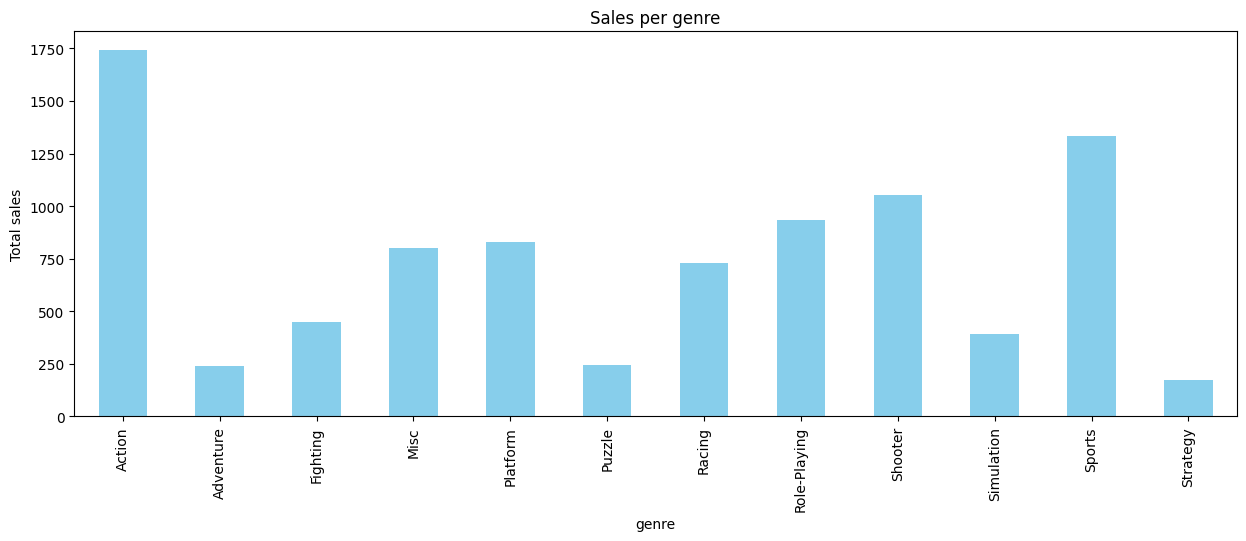

In [19]:
games_genre = games[games['genre'] != 'Unknown']
games_genre_sales = games_genre.groupby('genre')['total_sales'].sum()

plt.figure(figsize=(15,5))
plt.xlabel('Genre')
plt.ylabel('Total sales')
plt.title('Sales per genre')
games_genre_sales.plot(kind='bar', color = 'skyblue')

plt.show()

Los generos que destacan en ventas son accion y deportes, en una ligera menor medida podemos encontrar a los juegos de disparos, rol, platafoma y misterio. Los de menores ventas son aventura, estrategia y rompecabezas. 

### Perfiles de usuario por region 

#### Region Norteamerica

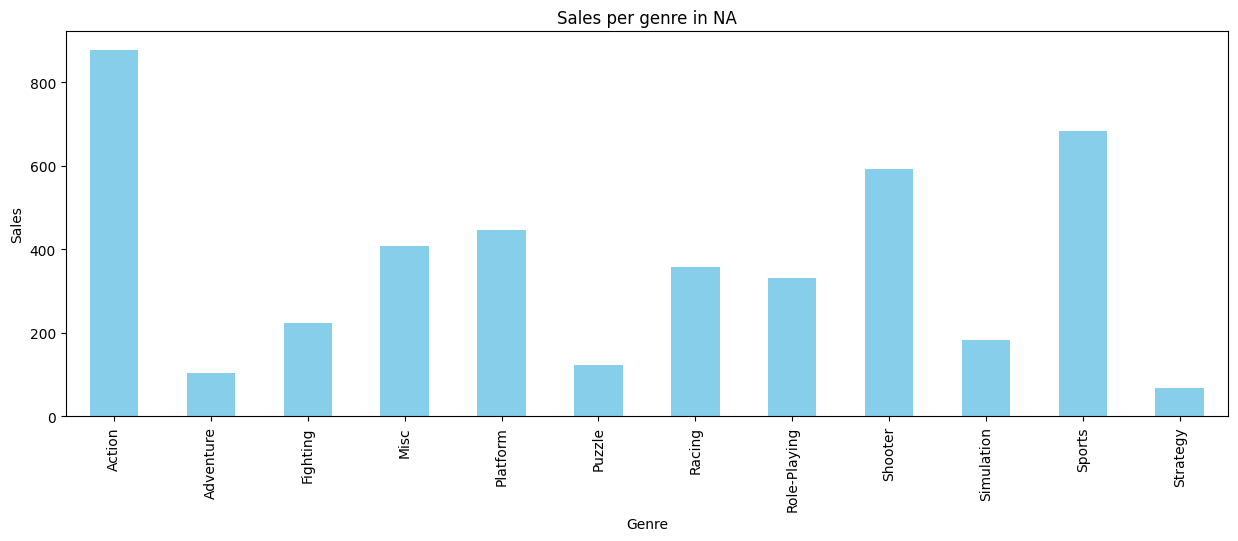

In [20]:

na_games = games_genre.query("na_sales > 0.01")[['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'critic_score', 'user_score', 'rating']]

top_genre_na = na_games.groupby('genre')['na_sales'].sum()

top_genre_na.plot(kind='bar', figsize=(15,5), xlabel='Genre', ylabel='Sales', title='Sales per genre in NA', color = 'skyblue')
plt.show()


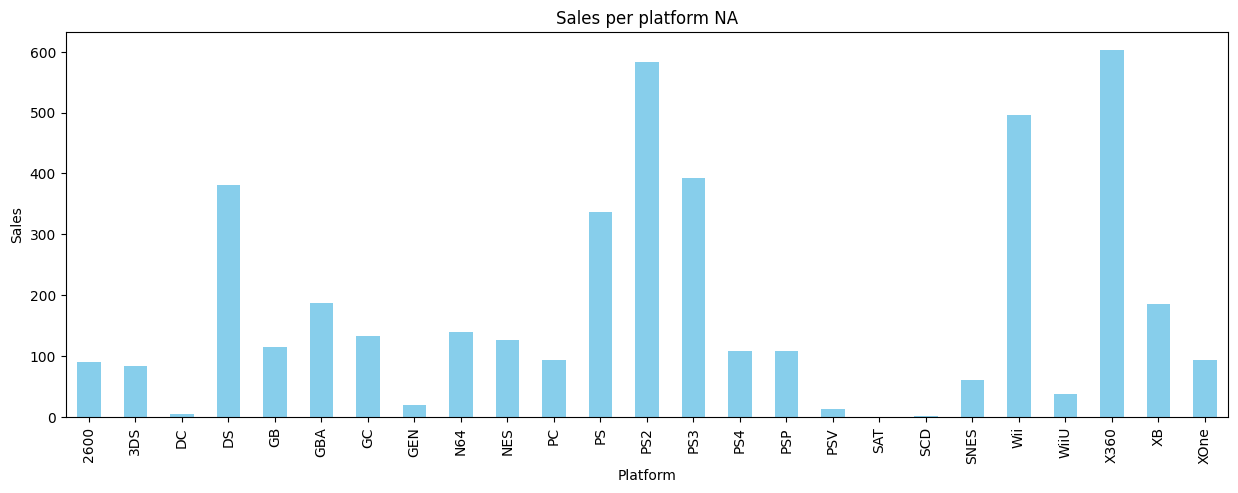

In [21]:
platforms_na = na_games.groupby('platform')['na_sales'].sum()

platforms_na.plot(kind='bar', figsize=(15,5), color = 'skyblue', xlabel='Platform', ylabel='Sales', title='Sales per platform NA')
plt.show()

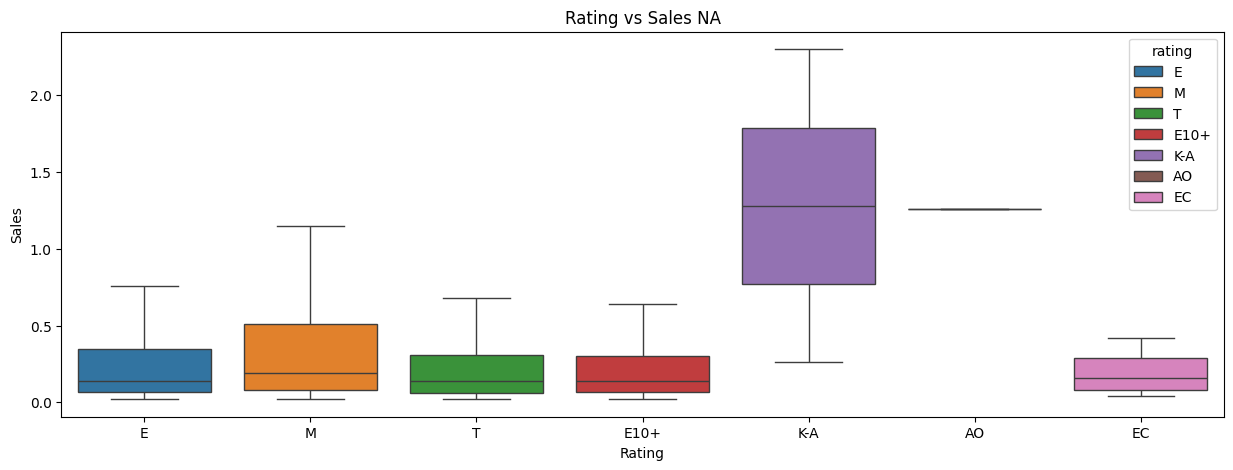

In [22]:

plt.figure(figsize = (15,5))


sns.boxplot(data=na_games, x='rating', y='na_sales', showfliers = False, hue= 'rating')
plt.title('Rating vs Sales NA')
plt.xlabel('Rating')
plt.ylabel('Sales')
plt.show()

In [23]:
sales_mean_na = na_games['na_sales'].mean()

sales_var_na = na_games['na_sales'].var()

print(f"La media del total de ventas en la region de Norteamerica es: {sales_mean_na}")

print(f"La varianza del total de ventas en la region de Norteamerica es: {sales_var_na}")

La media del total de ventas en la region de Norteamerica es: 0.37690764085412914
La varianza del total de ventas en la region de Norteamerica es: 0.9059644330642537


Para la region de **Norteamerica**, se llega a las siguientes conclusiones:
- Las 5 **plataformas** con mas ventas en esta region son xbox 360, playstation 2, nintendo wii, playstation 3 y nintendo DS 
- Los 5 **generos** principales son accion, deportes, disparos, plataformas y misterio 
- En esta region la mayoria de las **clasificaciones ESRB** presentan minimo, maximos y medianas similares a excepcion de la clasificacion K-A (clasificacion ulizada antes del año 2005 para referirse a los juegos aptos para niños y adultos) y AO (solo para adultos de 18 años en adelante) que presentan valores en ventas mas elevados. 

#### Region Europa 

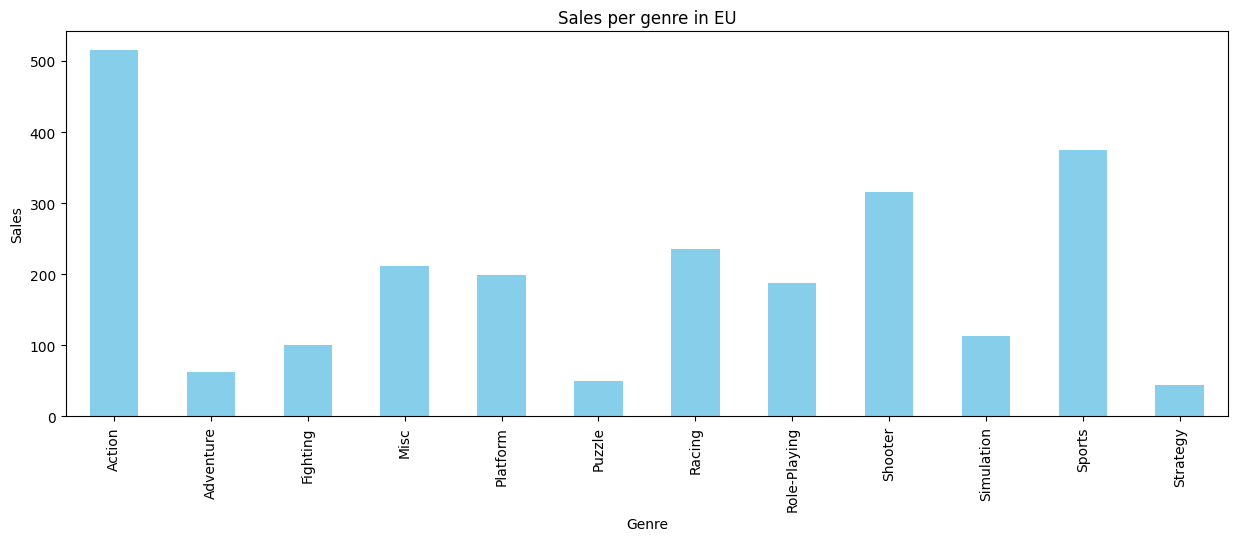

In [24]:
eu_games = games.query("eu_sales > 0.01 and genre != 'Unknown'")[['name', 'platform', 'year_of_release', 'genre', 'eu_sales', 'critic_score', 'user_score', 'rating']] 

top_genre_eu = eu_games.groupby('genre')['eu_sales'].sum()

top_genre_eu.plot(kind='bar', figsize=(15,5), xlabel='Genre', ylabel='Sales', title='Sales per genre in EU', color ='skyblue')
plt.show()


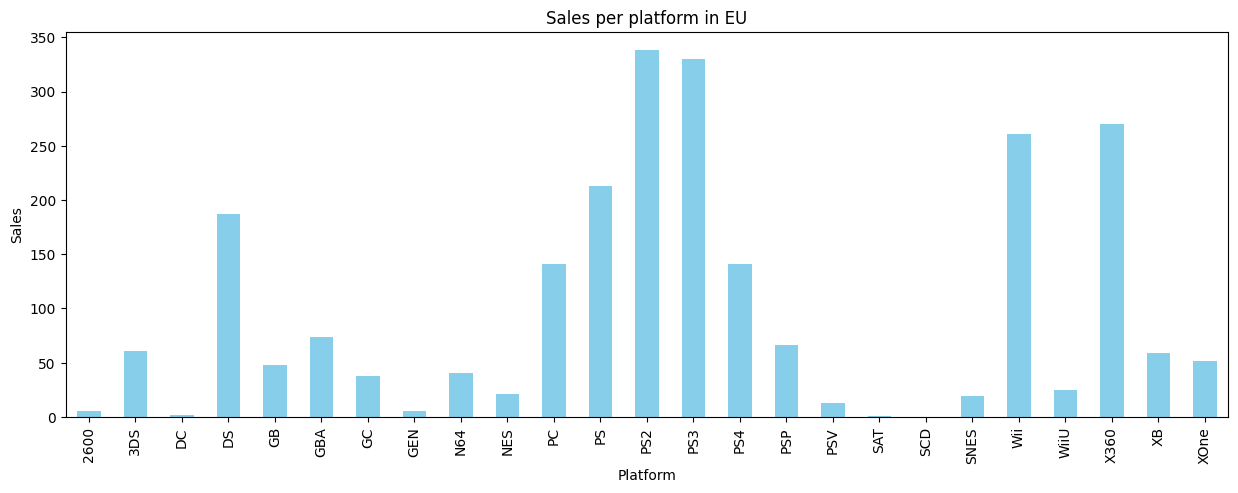

In [25]:
platforms_eu = eu_games.groupby('platform')['eu_sales'].sum()

platforms_eu.plot(kind='bar', figsize=(15,5), xlabel='Platform', ylabel='Sales', title='Sales per platform in EU', color ='skyblue')
plt.show()

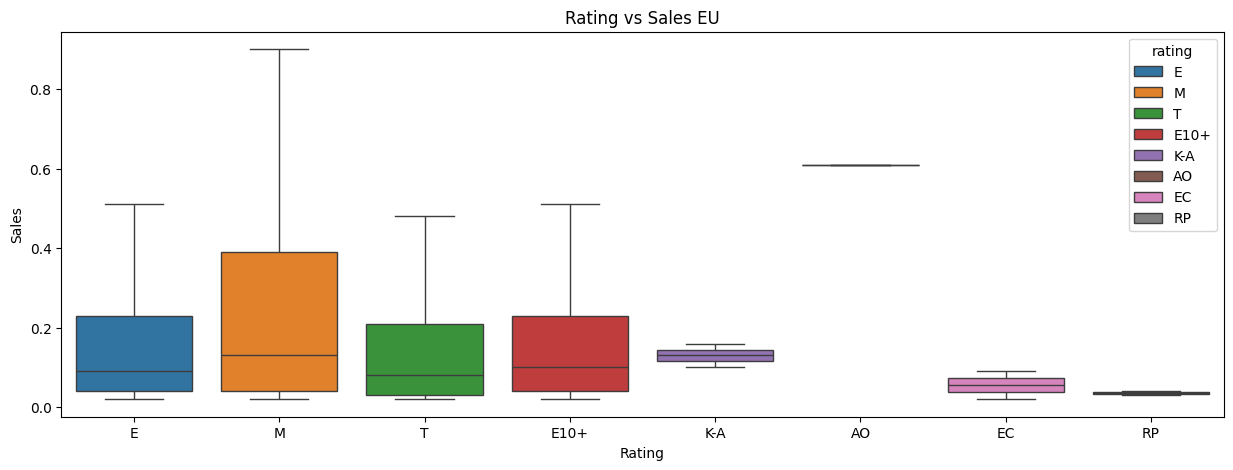

In [26]:
plt.figure(figsize = (15,5))

sns.boxplot(data=eu_games, x='rating', y='eu_sales', showfliers = False, hue= 'rating')
plt.title('Rating vs Sales EU')
plt.xlabel('Rating')
plt.ylabel('Sales')
plt.show()

In [27]:
sales_mean_eu = eu_games['eu_sales'].mean()

sales_var_eu = eu_games['eu_sales'].var()

print(f"La media del total de ventas en la region de Europa es: {sales_mean_eu}")

print(f"La varianza del total de ventas en la region de Europa es: {sales_var_eu}")

La media del total de ventas en la region de Europa es: 0.257668449197861
La varianza del total de ventas en la region de Europa es: 0.4241098055612914


Para la region de **Europa**, se llega a las siguientes conclusiones:
- Las 5 **plataformas** con mas ventas en esta region son playstation 1, 2 y 3, xbox 360 y nintendo wii
- Los 5 **generos** principales son accion, deportes, disparos, carreras, misterio 
- En esta region se observa mas variacion en ventas relacionado con la **clasificacion ESRB**; a diferencia los juegos K-A destacan mucho menos en las ventas, los clasificadoscomo AO (solamente adultos) presentan datos muy consentados. Los maximos en ventas en este caso los tiene la clasificacion M (mayores de 17 años)

#### Region Japon

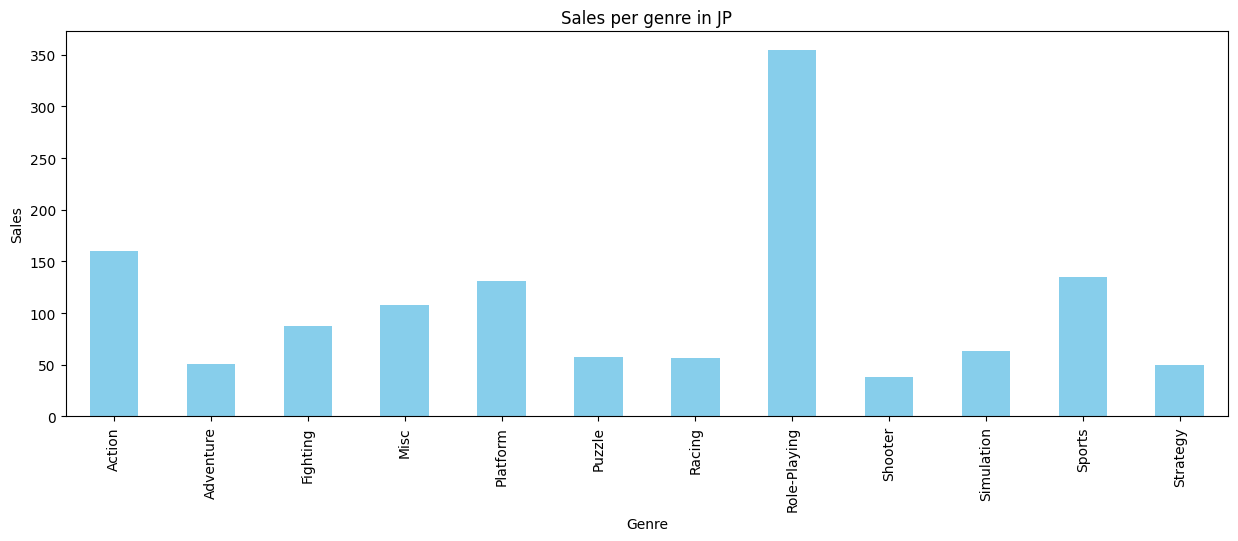

In [28]:
jp_games = games.query("jp_sales > 0.01 and genre != 'Unknown'")[['name', 'platform', 'year_of_release', 'genre', 'jp_sales', 'critic_score', 'user_score', 'rating']] 
top_genre_jp = jp_games.groupby('genre')['jp_sales'].sum()


top_genre_jp.plot(kind='bar', figsize=(15,5), xlabel='Genre', ylabel='Sales', title='Sales per genre in JP', color = 'skyblue')
plt.show()

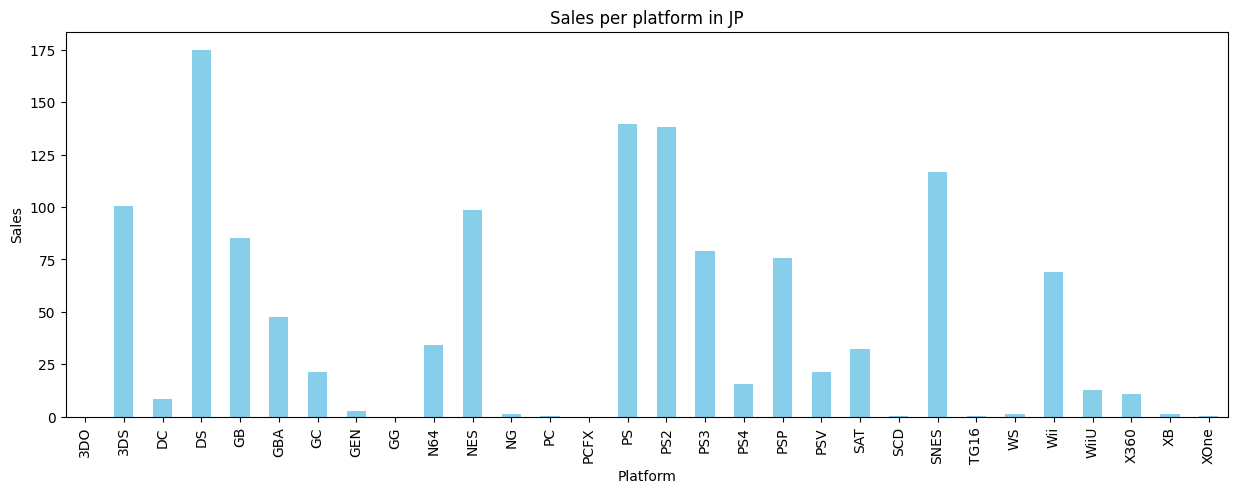

In [29]:
platforms_jp = jp_games.groupby('platform')['jp_sales'].sum()

platforms_jp.plot(kind='bar', figsize=(15,5), xlabel='Platform', ylabel='Sales', title='Sales per platform in JP', color ='skyblue')
plt.show()

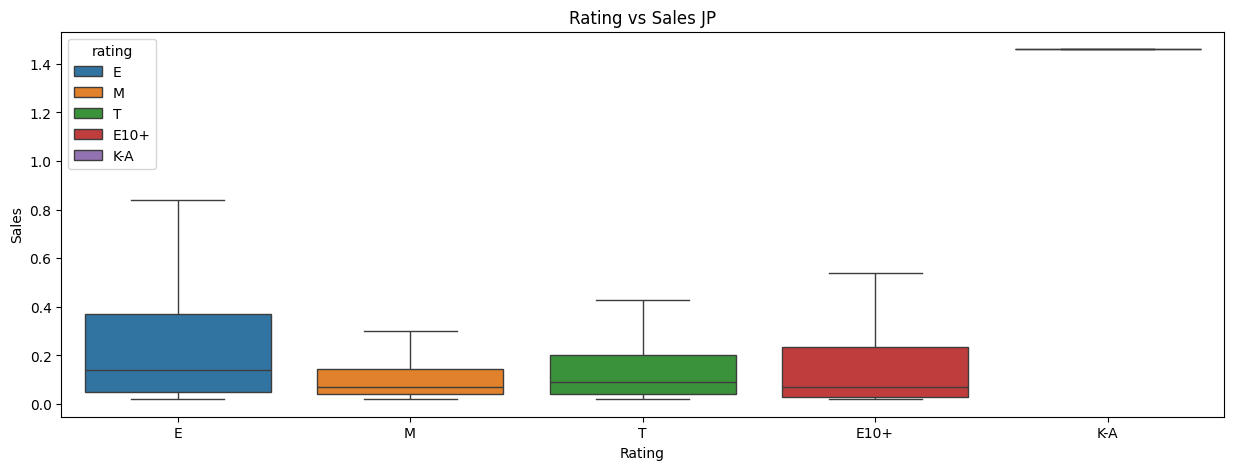

In [30]:
plt.figure(figsize = (15,5))

sns.boxplot(data=jp_games, x='rating', y='jp_sales', showfliers = False, hue= 'rating')
plt.title('Rating vs Sales JP')
plt.xlabel('Rating')
plt.ylabel('Sales')
plt.show()

In [31]:
sales_mean_jp = jp_games['jp_sales'].mean()

sales_var_jp = jp_games['jp_sales'].var()

print(f"La media del total de ventas en la region de Japon es: {sales_mean_jp}")

print(f"La varianza del total de ventas en la region de Japon es: {sales_var_jp}")

La media del total de ventas en la region de Japon es: 0.23485256643611208
La varianza del total de ventas en la region de Japon es: 0.25340557629324834


Para la region de **Japon**, se llega a las siguientes conclusiones:
- Las 5 **plataformas** con mas ventas en esta region son nintendo DS, playstation 1 y 2, NES y nintendo 3DS
- Los 5 **generos** principales son rol, accion, deportes, plataforma y misterio, observandose una predileccion clara por los juegos de rol. 
- En esta region las **clasificacion ESRB** guardan una distribucion similar en cuanto a ventas, destacandose E (apropiado para todo publico); se observa que algunas calificaciones no estan presentes en la grafica de ventas. Los clasificados como K-A tienen la menor amplitud de datos. 

### Cuotas entre regiones

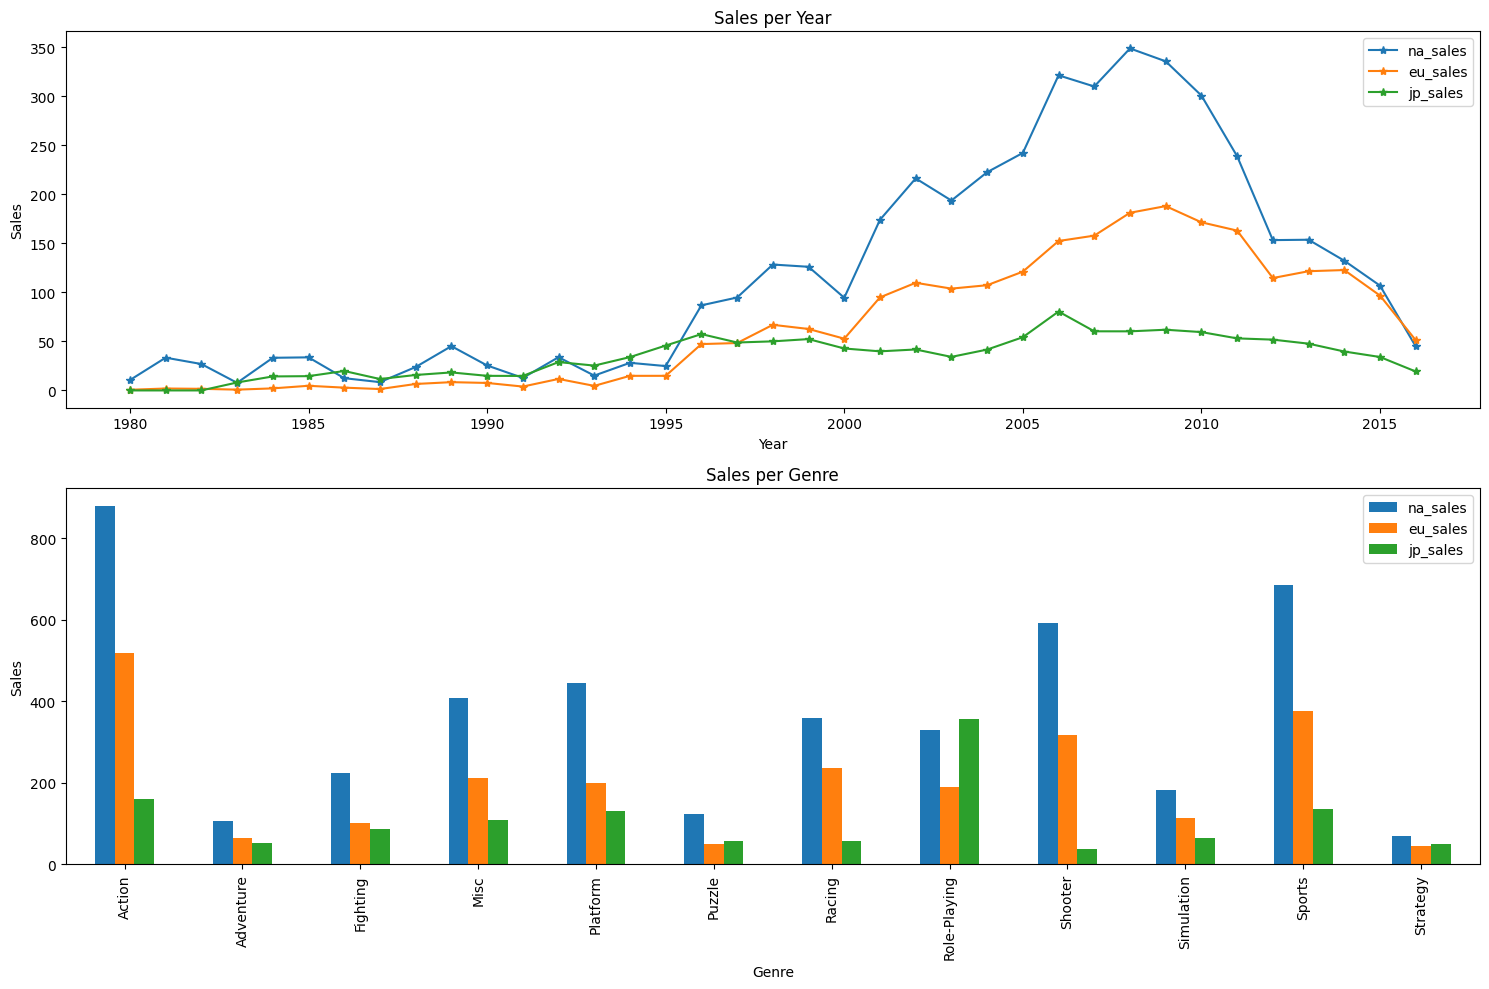

In [32]:
games1 = games[games['genre'] != 'Unknown']

agg_dict = {'na_sales' : 'sum', 'eu_sales' : 'sum', 'jp_sales' : 'sum'}
sales_year = games1.groupby(['year_of_release']).agg(agg_dict).reset_index()

agg_dict = {'na_sales' : 'sum', 'eu_sales' : 'sum', 'jp_sales' : 'sum'}
sales_genre = games1.groupby(['genre']).agg(agg_dict).reset_index()

fig, axs = plt.subplots(2, 1, figsize=(15, 10))

sales_year.plot(ax=axs[0], kind='line', x='year_of_release', style='*-')
axs[0].set_title('Sales per Year')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Sales')


sales_genre.plot(ax=axs[1], kind='bar', x='genre')
axs[1].set_title('Sales per Genre')
axs[1].set_xlabel('Genre')
axs[1].set_ylabel('Sales')

plt.tight_layout()
plt.show()


Derivado de los analisis por region realizados con anteriordad podemos concluir que:
- En todas las regiones se observan buenas ventas para una consola de las compañias insignia, es decir alguna generacion de xbox, playstation y nintendo; podemos concluir que cada una tiene un nicho de mercado ya arraigado por lo que apostar por sus consolas en turno no es mala idea.
- La diferencia mas grande en la popularidad de consolas se puede observar entre Japon y las otras regiones. Se observa que en Japon existe una fuere preferencia por las consolas de nintendo, en sus distintas versiones; tomando en cuenta que esta consola es de origen japones, podriamos suponer que esta es la raiz de sus altas ventas en dichan region. 
- Japon se diferencia tambien en el ambito de sus generos predilectos, mientras que en las otras regiones hay una fuerte predileccion por los juegos de accion, Japon prefiere los juegos de rol. 
- Además, se observa un impacto significativo de ciertas clasificaciones ESRB, como K-A y AO, en las ventas de los juegos. 
- La region lider en ventas parece ser Norteamerica, predominando la venta de videojuegos de accion; mientras que Japon es la region que presenta menores ventas.

## Pruebas de hipotesis

#### Hipotesis 1
Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son las mismas.

In [33]:
#h0 Las calificaciones promedio de los usuarios para las plataformas xbox one y pc son iguales 
#h1 las calificaciones promedio de los usuarios para las plataformas xbox one y pc son diferentes

users_xboxone = games[games['platform'] == 'XOne']['user_score'].dropna()

users_pc = games[games['platform'] == 'PC']['user_score'].dropna()

alpha = 0.05

In [34]:
_, pvalue_levene = levene(users_pc, users_xboxone)
if pvalue_levene < alpha:
    print(f'p-value:{pvalue_levene} - Rechazamos la hipotesis nula; las varianzas son iguales')
    equalvar = False
else:
    print(f'p-value:{pvalue_levene} - No Rechazamos la hipotesis nula, las varianzas son diferentes')
    equalvar = True
  

p-value:0.2693951512047048 - No Rechazamos la hipotesis nula, las varianzas son diferentes


In [35]:
_, pvalue = ttest_ind(users_pc, users_xboxone, equal_var=equalvar)

if pvalue < alpha:
    print(f'p-value:{pvalue} - Rechazamos la hipotesis nula; las calificaciones promedio de los usuarios no son iguales')
else:
    print(f'p-value:{pvalue} - No Rechazamos la hipotesis nula; las calificaciones promedio de los usuarios son iguales')

p-value:1.3896435533548819e-05 - Rechazamos la hipotesis nula; las calificaciones promedio de los usuarios no son iguales


#### Hipotesis 2
Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes.

In [36]:
#h0 Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son iguales
#h1Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes

score_action = games[games['genre'] == 'Action']['user_score'].dropna()

score_sports = games[games['genre'] == 'Sports']['user_score'].dropna()


In [37]:
_, pvalue_levene2 = levene(score_action, score_sports)
if pvalue_levene2 < alpha:
    print(f'p-value:{pvalue_levene2} - Rechazamos la hipotesis nula; las varianzas son iguales')
    equalvar2 = False
else:
    print(f'p-value:{pvalue_levene2} - No Rechazamos la hipotesis nula, las varianzas son diferentes')
    equalvar2 = True
  

p-value:0.0001736640672727649 - Rechazamos la hipotesis nula; las varianzas son iguales


In [38]:
_, pvalue2 = ttest_ind(score_action, score_sports, equal_var=equalvar2)

if pvalue2 < alpha:
    print(f'p-value:{pvalue2} - Rechazamos la hipotesis nula; las calificaciones promedio de los usuarios no son iguales')
else:
    print(f'p-value:{pvalue2} - No Rechazamos la hipotesis nula; las calificaciones promedio de los usuarios son iguales')

p-value:0.11483818791498286 - No Rechazamos la hipotesis nula; las calificaciones promedio de los usuarios son iguales


En cada caso, la hipótesis nula establece que no hay diferencia significativa entre las dos muestras (por ejemplo, las calificaciones promedio de usuarios para Xbox One y PC son iguales, o las calificaciones promedio de usuarios para los géneros de Acción y Deportes son iguales). Esta es la afirmación que buscamos probar o refutar con los datos. Por otro lado, la hipótesis alternativa sugiere que hay una diferencia significativa entre las muestras (por ejemplo, las calificaciones promedio de usuarios para Xbox One y PC son diferentes, o las calificaciones promedio de usuarios para los géneros de Acción y Deportes son diferentes). Esta es la afirmación que queremos apoyar si encontramos suficiente evidencia en los datos.

En este caso, utilizamos la prueba t de muestras independientes, que es apropiada cuando queremos comparar las medias de dos grupos diferentes de poblacion, los cuales en lo particular serian usuarios de xbox one y pc o usuarios jugadores de los generos accion y deportes.

El criterio utilizado para probar las hipótesis fue calcular el valor p asociado con cada prueba estadística. El valor p nos dice cuán probable es que las diferencias que observamos entre las muestras sean simplemente el resultado del azar. Si el valor p es menor que nuestro nivel de significancia alpha (establecido en 0.05), entonces tenemos evidencia suficiente para rechazar la hipótesis nula y concluir que hay diferencias significativas entre las muestras. Si el valor p es mayor que alpha, no tenemos suficiente evidencia para rechazar la hipótesis nula y no podemos concluir que hay diferencias significativas entre las muestras.


## Conclusiones generales

1. **Tendencias de lanzamientos y ventas:** Durante este tiempo, plataformas como Nintendo DS, PlayStation 2, 3 y 4, y Xbox 360 dominaron el mercado, mostrando un patrón común de declive en las ventas después de aproximadamente 8 a 10 años desde su lanzamiento.

2. **Rentabilidad de las plataformas:** A partir de los análisis, PS4 parece ser una plataforma con potencial de crecimiento para los próximos años, mientras que consolas anteriores como Nintendo DS y Xbox 360 están perdiendo popularidad. Este análisis sugiere la importancia de considerar el ciclo de vida de las consolas al planificar estrategias de desarrollo y comercialización.

3. **Impacto de las críticas en las ventas:** A pesar de la creencia común, las críticas de expertos y usuarios tienen una correlación casi nula con las ventas totales. Esto indica que otros factores, como el género del juego y la disponibilidad de títulos exclusivos, pueden tener un impacto más significativo en las decisiones de compra de los consumidores.

4. **Perfiles de usuario por región:** Se observan diferencias significativas en las preferencias de plataformas, géneros y clasificaciones ESRB entre las regiones de Norteamérica, Europa y Japón. Mientras que Norteamérica muestra una preferencia por consolas Xbox y PlayStation y juegos de acción, Japón tiende a favorecer las consolas Nintendo y juegos de rol.

5. **Hipotesis testeadas:** Los test realizados sobre las hipotesis, sugieren que hay una diferencia entresignificatica en las calificaciones promedio de los usuarios entre xbox one y pc. Es posible que esta diferencia este influenciada por factores como la calidad del hardware, la disponibilidad de juegos exclusivos y la experiencia del usuario en cada plataforma. Por lo que respecta a la segunda hipotesis que indica que no hay diferencia significativa en las calificaciones promedio de los usuarios entre los generos de accion y deportes. Es posible que los jugadores evaluen estos generos de manera similar dado la satisfaccion y experiencia de juego, lo cual tambien puede ir directamente relacionado con que son los generos mas populares o de los mas pupulares en todas las regiones. 





